In [14]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.stats import pearsonr, spearmanr
import h3pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
from warnings import filterwarnings
import matplotlib.colors as colors
import geopandas as gpd 
import sys
import os
import seaborn as sns

filterwarnings('ignore')
tqdm.pandas()

plt.rcParams.update({'font.family':'arial'})


In [15]:
with open('../trophic_niches.txt','r') as f:
    niche_list = f.read().strip().split('\n')

In [17]:
beta_geographic_summary = pd.read_csv('../../data/D07.BYM2_summary/beta_geographic_summary.csv')
beta_summary = pd.read_csv('../../data/D07.BYM2_summary/beta_summary.csv')

beta_geographic_summary = beta_geographic_summary[beta_geographic_summary['niche']!='all']
beta_summary = beta_summary[beta_summary['niche']!='all']


In [18]:
def plot_latitude_gradient(ax, beta_geographic_summary, beta_summary):
    trophic_niche = 'Trophic_Niche_Invertivore'
    tmp = beta_geographic_summary[beta_geographic_summary['niche']==trophic_niche]
    tmp2 = beta_summary[beta_summary['niche']==trophic_niche]

    # plot line 1
    data1 = tmp[tmp['env_var']=='tmin']
    sns.scatterplot(
        data = data1,
        x = 'lat',
        y = 'beta_mean',
        s=4,
        color='tab:orange',
        ax=ax,
    )

    xx = np.linspace(data1['lat'].min(), data1['lat'].max(), 100)
    centered_xx = xx - tmp.lat.mean()
    lat_beta_mean = tmp2[tmp2['env_var']=='tmin']['beta_lat_mean'].iloc[0]
    lat_beta_std = tmp2[tmp2['env_var']=='tmin']['beta_lat_std'].iloc[0]
    mu_beta_mean = tmp2[tmp2['env_var']=='tmin']['mu_beta_mean'].iloc[0]
    mu_beta_std = tmp2[tmp2['env_var']=='tmin']['mu_beta_std'].iloc[0]

    y_list = []
    for i in range(1000):
        mu_beta = np.random.normal(mu_beta_mean, mu_beta_std)
        lat_beta = np.random.normal(lat_beta_mean, lat_beta_std)
        y_ = [mu_beta + lat_beta * i for i in centered_xx]
        y_list.append(y_)
        
    y_list = np.array(y_list)

    ax.fill_between(
        x = xx,
        y1 = np.quantile(y_list, 0.025, axis=0),
        y2 = np.quantile(y_list, 0.975, axis=0),
        color='tab:orange',
        alpha=0.2
    )

    sns.lineplot(
        x = xx,
        y = np.mean(y_list, axis=0),
        color='tab:orange',
        linewidth=4,
        ax=ax,
        label='Temperature'
    )

    # plot line 2
    data1 = tmp[tmp['env_var']=='delta_NDVI']
    sns.scatterplot(
        data = data1,
        x = 'lat',
        y = 'beta_mean',
        s=4,
        color='tab:green',
        ax=ax,
    )

    xx = np.linspace(data1['lat'].min(), data1['lat'].max(), 100)
    centered_xx = xx - tmp.lat.mean()
    lat_beta_mean = tmp2[tmp2['env_var']=='delta_NDVI']['beta_lat_mean'].iloc[0]
    lat_beta_std = tmp2[tmp2['env_var']=='delta_NDVI']['beta_lat_std'].iloc[0]
    mu_beta_mean = tmp2[tmp2['env_var']=='delta_NDVI']['mu_beta_mean'].iloc[0]
    mu_beta_std = tmp2[tmp2['env_var']=='delta_NDVI']['mu_beta_std'].iloc[0]

    y_list = []
    for i in range(1000):
        mu_beta = np.random.normal(mu_beta_mean, mu_beta_std)
        lat_beta = np.random.normal(lat_beta_mean, lat_beta_std)
        y_ = [mu_beta + lat_beta * i for i in centered_xx]
        y_list.append(y_)
        
    y_list = np.array(y_list)

    ax.fill_between(
        x = xx,
        y1 = np.quantile(y_list, 0.025, axis=0),
        y2 = np.quantile(y_list, 0.975, axis=0),
        color='tab:green',
        alpha=0.2
    )

    sns.lineplot(
        x = xx,
        y = np.mean(y_list, axis=0),
        color='tab:green',
        linewidth=4,
        ax=ax,
        label='Green-up'
    )

    ax.set_xlabel('Latitude', fontsize=15)
    ax.set_ylabel('Phenological sensitivity\n(days per day)', fontsize=15)
    ax.legend(fontsize=15)
    ax.set_ylim(-0.1, 1.5)
    ax.set_xticklabels(['{:.0f}'.format(i) for i in ax.get_xticks()], fontsize=13)
    ax.set_yticklabels(['{:.1f}'.format(i) for i in ax.get_yticks()], fontsize=13)
    

In [19]:
# fig,ax = plt.subplots()

def plot_box_plot(ax, beta_summary):
    new_beta_summary = beta_summary.copy()
    new_beta_summary['env_var'] = [i.replace('_',' ') for i in new_beta_summary['env_var'].values]
    new_var_ = []


    colors = []
    for i in new_beta_summary['env_var'].values:
        if i == 'tmax':
            new_var_.append('Tmax')
        elif i == 'tmin':
            new_var_.append('Tmin')
        elif i == 'tmean':
            new_var_.append('Tmean')
        else:
            new_var_.append(i)

            
    new_beta_summary['env_var'] = new_var_

    sns.boxplot(
        data = new_beta_summary,
        x = 'env_var',
        y = 'beta_lat_mean',
        ax=ax,
        # hue='color',
        palette={"mean NDVI": "tab:green", "delta NDVI": "tab:green", 
                "Tmax": "tab:orange", "Tmin": "tab:orange", "Tmean": "tab:orange"}
    )

    sns.stripplot(x = "env_var",
                y = "beta_lat_mean",
                color = 'black',
                alpha = 0.3,
                data = new_beta_summary,
                ax=ax)

    ax.set_xlabel('Environmental variables', fontsize=15)
    ax.set_ylabel('Latitudial slope of\nphenological sensitivity\n(days per day per degree)', fontsize=15)
    ax.set_xticklabels([i.get_text().replace(' ','\n') for i in ax.get_xticklabels()], fontsize=13)
    ax.set_yticklabels(['{:.3f}'.format(i) for i in ax.get_yticks()], fontsize=13)


In [20]:

from plotting_utils import get_color_dict
color_dict = get_color_dict()


In [21]:
def plot_greenup_sensitivity(ax):
    import matplotlib
    
    tmp = beta_geographic_summary[
        (beta_geographic_summary['niche']=='Trophic_Niche_Invertivore') & (beta_geographic_summary['env_var']=='delta_NDVI')
    ]
    vmin, vmax = tmp['beta_mean'].min(), tmp['beta_mean'].max()
    norm = matplotlib.colors.Normalize(vmin=max(vmin, 0), vmax=vmax)
    
    tmp.set_index('h3_02').h3.h3_to_geo_boundary().plot('beta_mean',ax=ax, legend=False,cmap='viridis')
    
    cbar = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
    cb = plt.colorbar(cbar, ax=ax, shrink=0.35)
    cb.set_label(label="Sensitivity to green-up", fontsize=15)
    cb.set_ticklabels(["{:.1f}".format(float(i)) for i in cb.get_ticks()], fontsize=13)
    
    ax.set_xlabel('Longitude', fontsize=15)
    ax.set_ylabel('Latitude', fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)


def plot_temperature_sensitivity(ax):
    import matplotlib
    tmp = beta_geographic_summary[
        (beta_geographic_summary['niche']=='Trophic_Niche_Invertivore') & (beta_geographic_summary['env_var']=='tmin')
    ]
    vmin, vmax = tmp['beta_mean'].min(), tmp['beta_mean'].max()
    norm = matplotlib.colors.Normalize(vmin=max(vmin, 0), vmax=vmax)
    
    
    tmp.set_index('h3_02').h3.h3_to_geo_boundary().plot('beta_mean',ax=ax,legend=False,cmap='plasma')

    cbar = plt.cm.ScalarMappable(norm=norm, cmap='plasma')
    cb = plt.colorbar(cbar, ax=ax, shrink=0.35)
    cb.set_label(label="Sensitivity to temperature", fontsize=15)
    cb.set_ticklabels(["{:.1f}".format(float(i)) for i in cb.get_ticks()], fontsize=13)
    
    ax.set_xlabel('Longitude', fontsize=15)
    ax.set_ylabel('Latitude', fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)
    

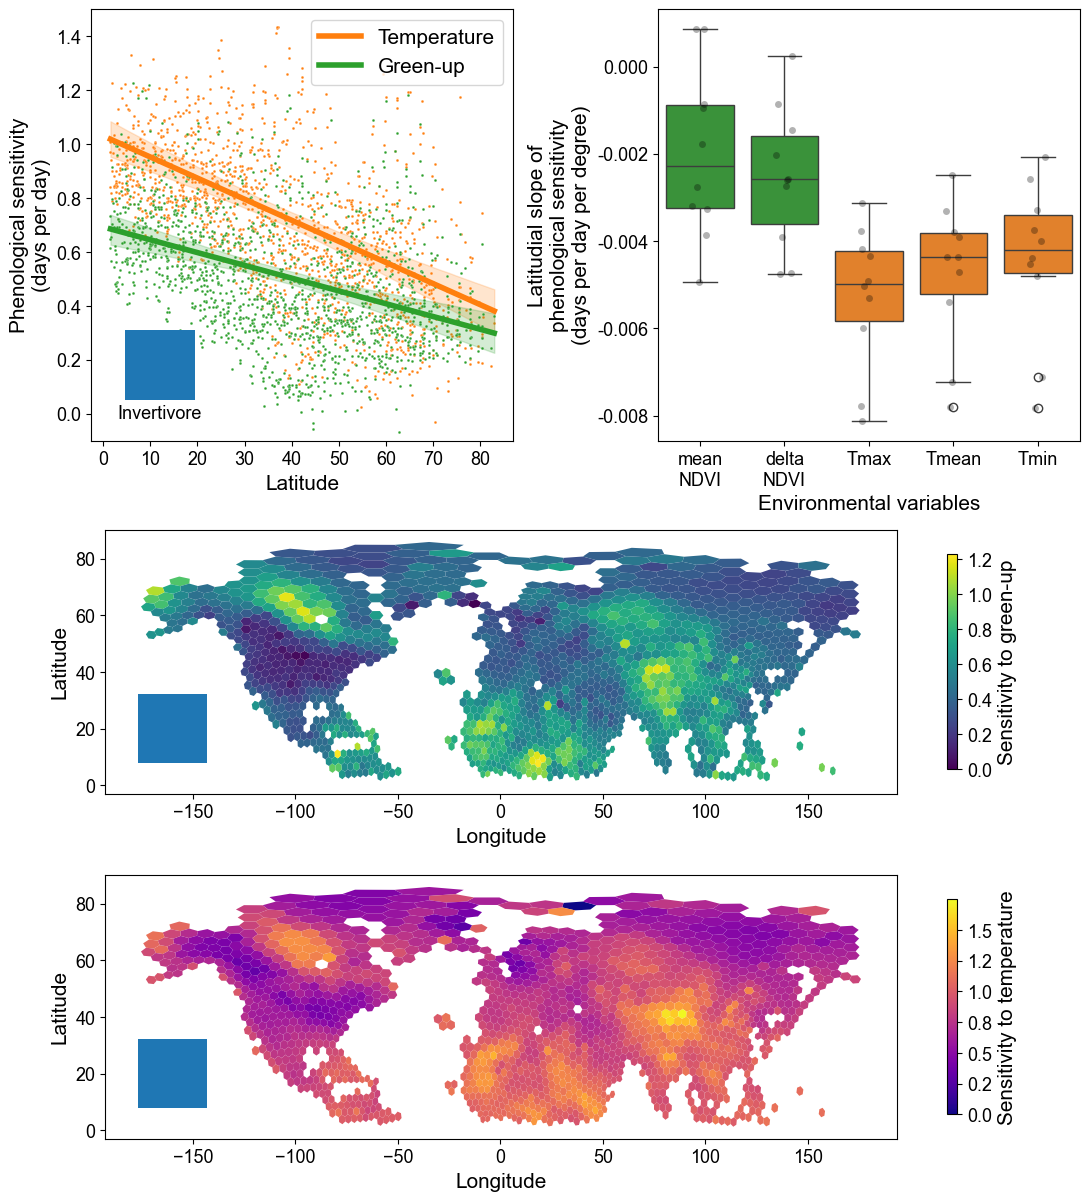

In [22]:

fig,axs = plt.subplots(3,2,figsize=(11,5*3),
                      gridspec_kw={'height_ratios': [1, 1, 1]})
plot_latitude_gradient(axs[0,0], 
                       beta_geographic_summary[beta_geographic_summary['niche'].isin(list(color_dict.keys()))], 
                       beta_summary[beta_summary['niche'].isin(list(color_dict.keys()))])

plot_box_plot(axs[0,1], beta_summary[beta_summary['niche'].isin(list(color_dict.keys()))])


gs = axs[0,0].get_gridspec()
# remove the underlying Axes
for ax in [axs[1,0], axs[1,1], axs[2,0], axs[2,1]]:
    ax.remove()
# axbig = fig.add_subplot(gs[1:,0:])
axbig1 = fig.add_axes([0.1, 0.35, 0.9, 0.41])
plot_greenup_sensitivity(axbig1)
axbig2 = fig.add_axes([0.1, 0.12, 0.9, 0.41])
plot_temperature_sensitivity(axbig2)

plt.tight_layout()


import skunk
from matplotlib.offsetbox import AnnotationBbox
size=(50,50)

box = skunk.Box(size[0], size[1], 'Trophic_Niche_Invertivore')
ab = AnnotationBbox(box, (12,0.18),
                    xycoords='data',
                    boxcoords='data',
                    frameon=False)
axs[0,0].add_artist(ab)
axs[0,0].annotate('Invertivore',
            xy=(12,0),  # Position to place the annotation text
            fontsize=13,
            ha='center',va='center')


box = skunk.Box(size[0], size[1], 'leaf')
ab = AnnotationBbox(box, (-160,20),
                    xycoords='data',
                    boxcoords='data',
                    frameon=False)
axbig1.add_artist(ab)
        
box = skunk.Box(size[0], size[1], 'temperature')
ab = AnnotationBbox(box, (-160,20),
                    xycoords='data',
                    boxcoords='data',
                    frameon=False)
axbig2.add_artist(ab)

plt.tight_layout()

svg = skunk.insert({'Trophic_Niche_Invertivore':f"../../silhouette/SVG/Trophic_Niche_Invertivore.svg",
                    'leaf':f"../../silhouette/SVG/leaf.svg",
                    'temperature':f"../../silhouette/SVG/temperature.svg"})

import cairosvg
cairosvg.svg2pdf(bytestring=svg, write_to='Fig3.pdf')

# svg = skunk.insert({'Trophic_Niche_Invertivore':f"../../silhouette/SVG/Trophic_Niche_Invertivore.svg"})

# # plot_temperature_sensitivity(axs[1,1])
# import cairosvg
# cairosvg.svg2pdf(bytestring=svg, write_to='Fig3.pdf')

# plt.savefig('./Fig3.pdf')



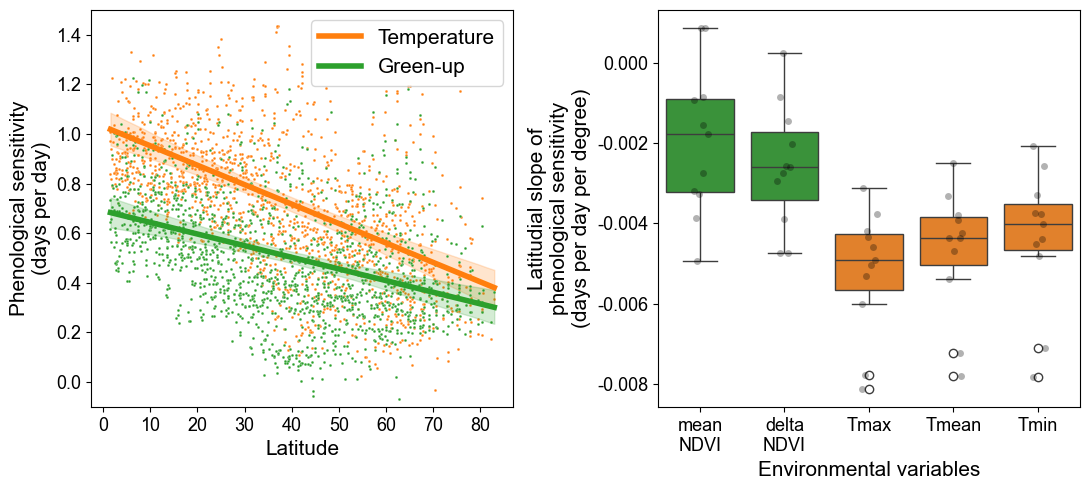

In [106]:
fig,ax = plt.subplots(1,2,figsize=(11,5))
plot_latitude_gradient(ax[0], 
                       beta_geographic_summary[beta_geographic_summary['niche'].isin(list(color_dict.keys()))], 
                       beta_summary[beta_summary['niche'].isin(list(color_dict.keys()))])
plot_box_plot(ax[1], beta_summary[beta_summary['niche'].isin(list(color_dict.keys()))])
plt.tight_layout()
plt.savefig('./Fig3.pdf')


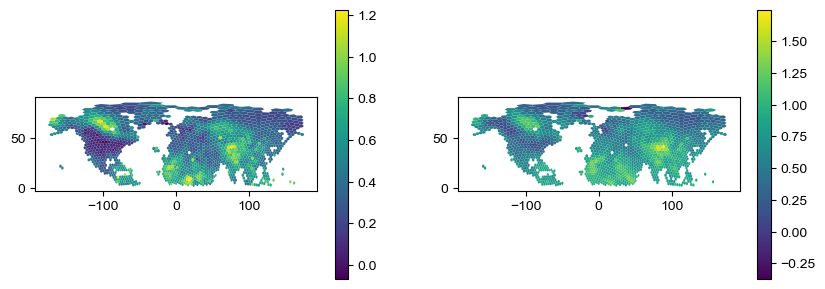

<Axes: >

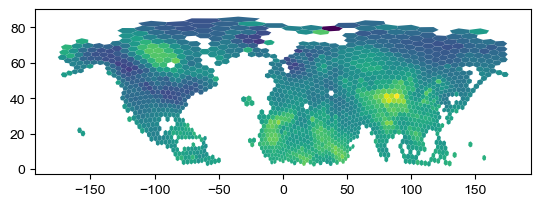

In [23]:
beta_geographic_summary

,h3_02,lng,lat,dist,cell_index,year_data_count,beta_mean,beta_std,niche,env_var,season
0,820007fffffffff,36.216216,77.747748,1,0,4.0,0.485506,0.201644,all,mean_NDVI,spring
1,82001ffffffffff,46.666667,79.549550,1,3,5.0,0.449566,0.195001,all,mean_NDVI,spring
2,820027fffffffff,28.648649,75.765766,1,4,6.0,0.658203,0.147005,all,mean_NDVI,spring
3,82002ffffffffff,22.882883,78.108108,1,5,6.0,0.482447,0.193780,all,mean_NDVI,spring
4,82004ffffffffff,-37.297297,82.972973,1,8,5.0,0.394453,0.191282,all,mean_NDVI,spring
...,...,...,...,...,...,...,...,...,...,...,...
112455,827af7fffffffff,43.783784,4.054054,1,2651,7.0,0.965436,0.183758,Trophic_Level_Scavenger,tmin,spring
112456,828297fffffffff,15.675676,1.891892,1,2674,5.0,1.073422,0.196483,Trophic_Level_Scavenger,tmin,spring
112457,82829ffffffffff,13.153153,2.972973,1,2675,4.0,0.999695,0.221668,Trophic_Level_Scavenger,tmin,spring
112458,8282d7fffffffff,8.468468,2.252252,1,2677,4.0,0.921582,0.225457,Trophic_Level_Scavenger,tmin,spring
